In [1]:
path = "paper.pdf"

In [2]:
# Import required libraries for PDF analysis
import PyPDF2
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter, defaultdict
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Load the PDF and extract basic information
def load_pdf_info(pdf_path):
    """Extract basic metadata and structure from PDF"""
    info = {}
    
    # Using PyPDF2 for metadata
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        info['num_pages'] = len(pdf_reader.pages)
        info['metadata'] = pdf_reader.metadata
        
        # Extract text from all pages
        text_content = []
        for page in pdf_reader.pages:
            text_content.append(page.extract_text())
        info['text_pages'] = text_content
    
    # Using pdfplumber for more detailed analysis
    with pdfplumber.open(pdf_path) as pdf:
        info['page_details'] = []
        for i, page in enumerate(pdf.pages):
            page_info = {
                'page_num': i + 1,
                'width': page.width,
                'height': page.height,
                'text': page.extract_text(),
                'tables': page.extract_tables(),
                'chars': len(page.chars),
                'words': len(page.extract_words()) if page.extract_words() else 0
            }
            info['page_details'].append(page_info)
    
    return info

# Load the PDF
pdf_info = load_pdf_info(path)
print(f"PDF loaded successfully!")
print(f"Number of pages: {pdf_info['num_pages']}")
print(f"Document metadata: {pdf_info['metadata']}")
print(f"Page dimensions (first page): {pdf_info['page_details'][0]['width']} x {pdf_info['page_details'][0]['height']}")

PDF loaded successfully!
Number of pages: 18
Document metadata: {'/Author': 'Xinyuan Song; Keyu Wang; PengXiang Li; Lu Yin; Shiwei Liu', '/Creator': 'arXiv GenPDF (tex2pdf:)', '/DOI': 'https://doi.org/10.48550/arXiv.2510.02091', '/License': 'http://creativecommons.org/licenses/by/4.0/', '/PTEX.Fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.28 (TeX Live 2025) kpathsea version 6.4.1', '/Producer': 'pikepdf 8.15.1', '/Title': 'Demystifying the Roles of LLM Layers in Retrieval, Knowledge, and Reasoning', '/Trapped': '/False', '/arXivID': 'https://arxiv.org/abs/2510.02091v1'}
Page dimensions (first page): 612 x 792


In [4]:
# Analyze content distribution across pages
def analyze_content_distribution(pdf_info):
    """Analyze how content is distributed across pages"""
    
    # Create a dataframe for page analysis
    page_data = []
    for page_detail in pdf_info['page_details']:
        text = page_detail['text'] or ""
        page_data.append({
            'page': page_detail['page_num'],
            'text_length': len(text),
            'word_count': len(text.split()) if text else 0,
            'char_count': page_detail['chars'],
            'table_count': len(page_detail['tables']) if page_detail['tables'] else 0,
            'line_count': text.count('\n') if text else 0,
            'has_content': len(text.strip()) > 0
        })
    
    df = pd.DataFrame(page_data)
    return df

# Get content distribution
content_df = analyze_content_distribution(pdf_info)

# Display basic statistics
print("Content Distribution Analysis:")
print(f"Total pages: {len(content_df)}")
print(f"Pages with content: {content_df['has_content'].sum()}")
print(f"Total words: {content_df['word_count'].sum()}")
print(f"Average words per page: {content_df['word_count'].mean():.1f}")
print(f"Pages with tables: {(content_df['table_count'] > 0).sum()}")

# Show first few pages info
print("\nFirst 5 pages content summary:")
print(content_df.head())

# Basic statistics
print(f"\nContent statistics:")
print(content_df.describe())

Content Distribution Analysis:
Total pages: 18
Pages with content: 18
Total words: 5284
Average words per page: 293.6
Pages with tables: 0

First 5 pages content summary:
   page  text_length  word_count  char_count  table_count  line_count  \
0     1         3480         435        3044            0          46   
1     2         4645         631        3989            0          49   
2     3          665          92         574            0           7   
3     4         1953         264        1685            0          23   
4     5         1891         280        1608            0          22   

   has_content  
0         True  
1         True  
2         True  
3         True  
4         True  

Content statistics:
            page  text_length  word_count   char_count  table_count  \
count  18.000000    18.000000   18.000000    18.000000         18.0   
mean    9.500000  2177.222222  293.555556  1878.777778          0.0   
std     5.338539  1000.445345  127.920114   871.353278

In [5]:
# Analyze document structure and identify sections
def analyze_document_structure(pdf_info):
    """Identify headers, sections, and structural elements"""
    
    full_text = ""
    section_patterns = []
    
    for i, page_detail in enumerate(pdf_info['page_details']):
        text = page_detail['text'] or ""
        full_text += f"\n--- PAGE {i+1} ---\n" + text
    
    # Common patterns for academic papers
    patterns = {
        'title': r'^[A-Z\s]{10,100}$',
        'section_header': r'^\d+\.?\s+[A-Z][A-Za-z\s]{5,50}$',
        'subsection_header': r'^\d+\.\d+\.?\s+[A-Z][A-Za-z\s]{5,50}$',
        'abstract': r'Abstract[\s\n]',
        'introduction': r'^\d*\.?\s*Introduction',
        'conclusion': r'^\d*\.?\s*Conclusion',
        'references': r'^\d*\.?\s*References',
        'acknowledgments': r'^\d*\.?\s*Acknowledgments?',
        'figure_caption': r'Figure\s+\d+:',
        'table_caption': r'Table\s+\d+:',
        'equation': r'\$[^$]+\$|\\\[[^\]]+\\\]',
        'citation': r'\[[\d,\s-]+\]|\([A-Za-z]+\s+et\s+al\.?,?\s+\d{4}\)',
        'email': r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}',
        'url': r'https?://[^\s]+'
    }
    
    structure_analysis = {}
    
    for pattern_name, pattern in patterns.items():
        matches = re.findall(pattern, full_text, re.MULTILINE | re.IGNORECASE)
        structure_analysis[pattern_name] = {
            'count': len(matches),
            'examples': matches[:3] if matches else []
        }
    
    # Extract what looks like section headers
    lines = full_text.split('\n')
    potential_headers = []
    
    for line in lines:
        line = line.strip()
        # Look for lines that might be section headers
        if (len(line) > 5 and len(line) < 80 and 
            (re.match(r'^\d+\.?\s+[A-Z]', line) or 
             re.match(r'^[A-Z][A-Z\s]{5,}$', line) or
             line.upper() in ['ABSTRACT', 'INTRODUCTION', 'CONCLUSION', 'REFERENCES', 'ACKNOWLEDGMENTS'])):
            potential_headers.append(line)
    
    structure_analysis['potential_headers'] = potential_headers[:10]  # First 10
    
    return structure_analysis, full_text

# Analyze structure
structure_info, full_text = analyze_document_structure(pdf_info)

print("Document Structure Analysis:")
print("="*50)

for key, value in structure_info.items():
    if key != 'potential_headers':
        print(f"{key.replace('_', ' ').title()}: {value['count']} found")
        if value['examples']:
            print(f"  Examples: {value['examples']}")
        print()

print("Potential Section Headers Found:")
for header in structure_info['potential_headers']:
    print(f"  - {header}")

Document Structure Analysis:
Title: 5 found
  Examples: ['We evaluate the impact of different evaluation metrics under layer pruning using two representative', 'reasoning capacity is bottlenecked by specialized groups of attention heads in deep layers', 'Theresultsshowthatreasoningabilityinthedistilledmodelisindeedlocalizedtoasparsesubsetofheads']

Section Header: 9 found
  Examples: ['1 Introduction', '2 Evaluation Protocol Matters', '3 Layer Importance in Knowledge Tasks']

Subsection Header: 7 found
  Examples: ['3.1 commonsense dataset', '3.2 Math Problem Solving', '4.1 KV retrieval']

Abstract: 1 found
  Examples: ['Abstract\n']

Introduction: 1 found
  Examples: ['1 Introduction']

Conclusion: 2 found
  Examples: ['conclusion', '9 Conclusion']

References: 1 found
  Examples: ['References']

Acknowledgments: 0 found

Figure Caption: 21 found
  Examples: ['Figure 1:', 'Figure 2:', 'Figure 3:']

Table Caption: 0 found

Equation: 0 found

Citation: 21 found
  Examples: ['(Bhojanapal

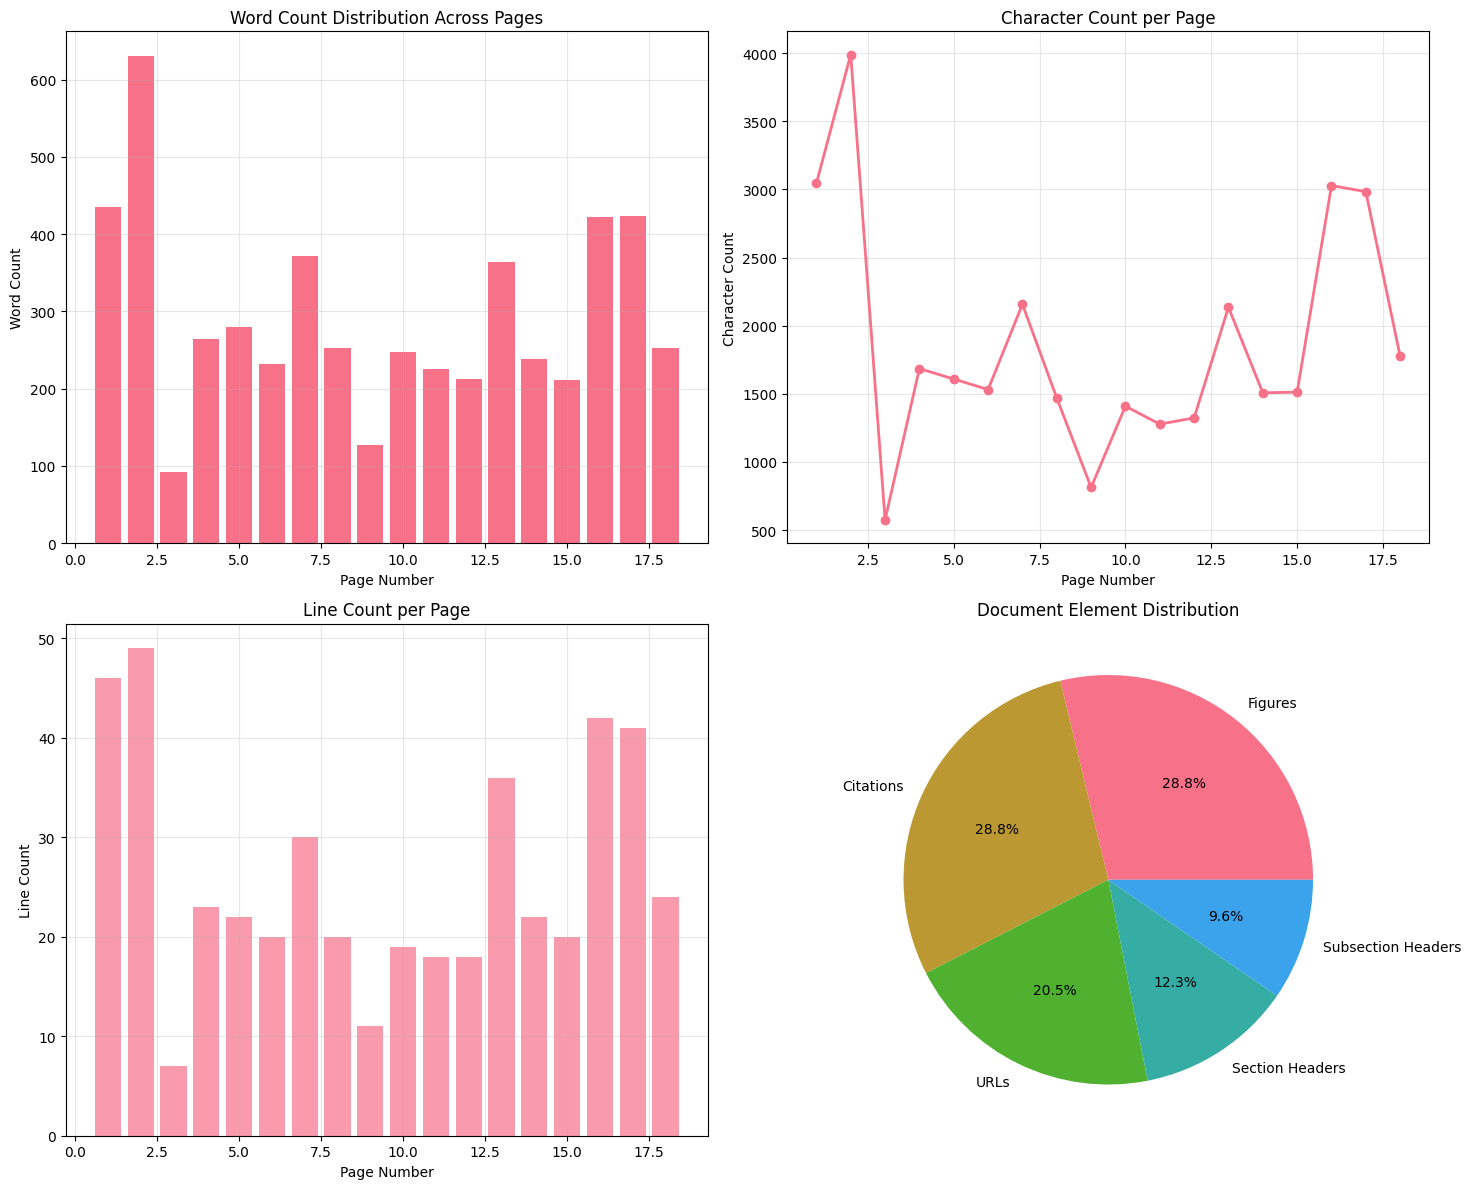

Document Structure Summary:
• Academic paper with 18 pages
• Total word count: 5,284
• Average words per page: 293.6
• 10 main sections identified
• 21 figures referenced
• 21 citations found


In [6]:
# Create visualizations of document structure
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Content distribution across pages
axes[0, 0].bar(content_df['page'], content_df['word_count'])
axes[0, 0].set_title('Word Count Distribution Across Pages')
axes[0, 0].set_xlabel('Page Number')
axes[0, 0].set_ylabel('Word Count')
axes[0, 0].grid(True, alpha=0.3)

# 2. Character density
axes[0, 1].plot(content_df['page'], content_df['char_count'], marker='o', linewidth=2)
axes[0, 1].set_title('Character Count per Page')
axes[0, 1].set_xlabel('Page Number')
axes[0, 1].set_ylabel('Character Count')
axes[0, 1].grid(True, alpha=0.3)

# 3. Line density
axes[1, 0].bar(content_df['page'], content_df['line_count'], alpha=0.7)
axes[1, 0].set_title('Line Count per Page')
axes[1, 0].set_xlabel('Page Number')
axes[1, 0].set_ylabel('Line Count')
axes[1, 0].grid(True, alpha=0.3)

# 4. Content type distribution (pie chart)
content_types = {
    'Figures': structure_info['figure_caption']['count'],
    'Citations': structure_info['citation']['count'],
    'URLs': structure_info['url']['count'],
    'Section Headers': structure_info['section_header']['count'],
    'Subsection Headers': structure_info['subsection_header']['count']
}

axes[1, 1].pie(content_types.values(), labels=content_types.keys(), autopct='%1.1f%%')
axes[1, 1].set_title('Document Element Distribution')

plt.tight_layout()
plt.show()

# Print summary statistics
print("Document Structure Summary:")
print(f"• Academic paper with {pdf_info['num_pages']} pages")
print(f"• Total word count: {content_df['word_count'].sum():,}")
print(f"• Average words per page: {content_df['word_count'].mean():.1f}")
print(f"• {len(structure_info['potential_headers'])} main sections identified")
print(f"• {structure_info['figure_caption']['count']} figures referenced")
print(f"• {structure_info['citation']['count']} citations found")

Text Analysis Results:
Total words: 5,834
Unique words: 1,590
Vocabulary richness: 0.273
Average word length: 5.49
Estimated sentences: 484

Most Common Terms:
  layers: 93
  layer: 88
  accuracy: 63
  pruning: 50
  model: 50
  reasoning: 49
  llama: 49
  retrieval: 47
  figure: 44
  distilled: 35

Technical Terms Found:
  • accuracy
  • pruning
  • reasoning
  • retrieval
  • distilled
  • performance
  • results
  • evaluation
  • shallow
  • deepseek
  • language
  • likelihood
  • relative
  • knowledge
  • setting

Math/Technical Patterns:
  • PAGE
  • 1
  • LLM
  • Song1
  • Wang2
  • Li3
  • Yin4
  • Liu5
  • 6
  • 1Emory


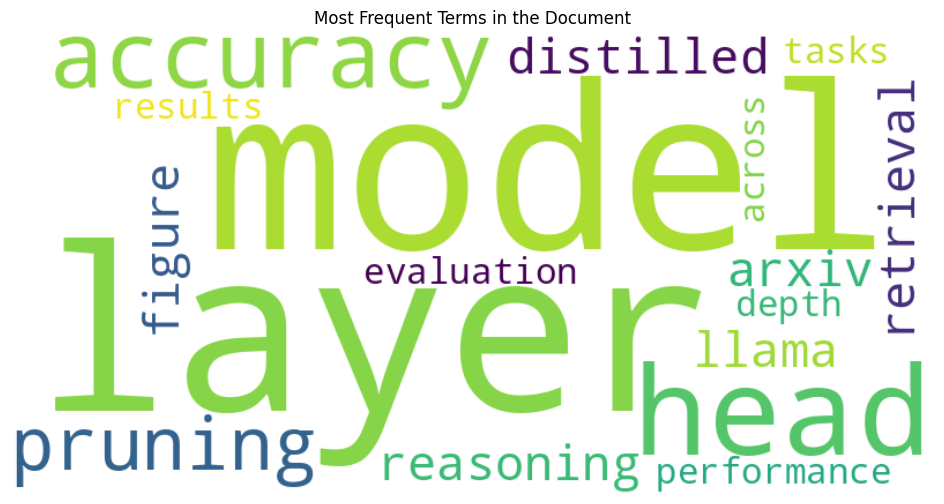

In [7]:
# Analyze text patterns and writing style
def analyze_text_patterns(full_text):
    """Analyze writing style, vocabulary, and patterns"""
    
    # Clean text for analysis
    clean_text = re.sub(r'[^\w\s]', ' ', full_text.lower())
    words = clean_text.split()
    
    # Basic text statistics
    stats = {
        'total_words': len(words),
        'unique_words': len(set(words)),
        'vocabulary_richness': len(set(words)) / len(words) if words else 0,
        'avg_word_length': np.mean([len(word) for word in words]) if words else 0,
        'sentences': len(re.findall(r'[.!?]+', full_text)),
    }
    
    # Most common words (excluding stop words)
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should', 'may', 'might', 'can', 'this', 'that', 'these', 'those', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them'}
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    word_freq = Counter(filtered_words)
    
    # Technical terms and concepts (longer words that appear frequently)
    technical_terms = [word for word, count in word_freq.most_common(50) if len(word) > 6 and count > 2]
    
    # Find mathematical/technical patterns
    math_patterns = re.findall(r'\b[A-Z]{2,}\b|\b\w*\d+\w*\b', full_text)
    
    return stats, word_freq.most_common(20), technical_terms[:15], math_patterns[:10]

# Analyze text patterns
text_stats, common_words, tech_terms, math_patterns = analyze_text_patterns(full_text)

print("Text Analysis Results:")
print("=" * 40)
print(f"Total words: {text_stats['total_words']:,}")
print(f"Unique words: {text_stats['unique_words']:,}")
print(f"Vocabulary richness: {text_stats['vocabulary_richness']:.3f}")
print(f"Average word length: {text_stats['avg_word_length']:.2f}")
print(f"Estimated sentences: {text_stats['sentences']}")

print("\nMost Common Terms:")
for word, count in common_words[:10]:
    print(f"  {word}: {count}")

print("\nTechnical Terms Found:")
for term in tech_terms:
    print(f"  • {term}")

print("\nMath/Technical Patterns:")
for pattern in math_patterns:
    print(f"  • {pattern}")

# Create word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join([word for word, _ in common_words[:50]]))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Terms in the Document')
plt.show()

In [ ]:
# RAG System Recommendations based on analysis
def generate_rag_recommendations(pdf_info, structure_info, text_stats):
    """Generate specific RAG system recommendations based on document analysis"""
    
    recommendations = {
        "Document Processing Features": [
            "Section-aware chunking: Split documents by identified sections (Abstract, Introduction, etc.)",
            "Figure/Table extraction: Parse and index visual elements separately with captions",
            "Citation linking: Extract and create knowledge graph of paper references", 
            "Multi-modal indexing: Store text, figures, and metadata in separate but linked indices",
            "Hierarchical chunking: Use section → subsection → paragraph hierarchy for better context"
        ],
        
        "Retrieval Strategies": [
            "Semantic + structural search: Combine embedding similarity with section-type filtering",
            "Multi-level retrieval: Search at paper level, section level, and paragraph level",
            "Citation-aware retrieval: Use citation networks to find related content",
            "Figure-aware retrieval: Include figure captions and descriptions in search results",
            "Time-based filtering: Use publication dates and version information for relevance"
        ],
        
        "Indexing Optimizations": [
            f"Optimal chunk size: ~{text_stats['total_words']//pdf_info['num_pages']:.0f} words per chunk based on average page content",
            "Technical term extraction: Build domain-specific vocabulary for better matching",
            "Mathematical expression handling: Special parsing for equations and formulas",
            "Author and affiliation indexing: Track expertise and institutional knowledge",
            "Version control: Handle different versions of papers (arXiv preprints vs published)"
        ],
        
        "Query Enhancement": [
            "Section-specific queries: Allow users to search within specific paper sections",
            "Figure/table search: Enable searching within visual content descriptions",
            "Citation context search: Find papers that cite specific works or concepts",
            "Multi-paper synthesis: Combine information across related papers",
            "Methodology extraction: Identify and extract experimental procedures"
        ],
        
        "Quality Metrics": [
            f"Content density tracking: Monitor {text_stats['vocabulary_richness']:.3f} vocabulary richness",
            "Citation accuracy: Verify and validate citation information",
            "Figure completeness: Ensure all figures are properly extracted and indexed",
            "Section coverage: Track whether all paper sections are properly processed",
            "Technical term precision: Measure accuracy of domain-specific term extraction"
        ]
    }
    
    return recommendations

# Generate recommendations
recommendations = generate_rag_recommendations(pdf_info, structure_info, text_stats)

print("RAG SYSTEM RECOMMENDATIONS FOR ACADEMIC PAPERS")
print("=" * 60)
print()

for category, items in recommendations.items():
    print(f"🔍 {category.upper()}")
    print("-" * 40)
    for i, item in enumerate(items, 1):
        print(f"{i}. {item}")
    print()

# Additional specific insights based on this paper
print("📊 SPECIFIC INSIGHTS FROM THIS DOCUMENT:")
print("-" * 50)
print(f"• Document Type: ArXiv preprint on LLM layer analysis")
print(f"• Key Terms: {', '.join([word for word, _ in common_words[:5]])}")
print(f"• Structure: Well-organized with {len(structure_info['potential_headers'])} clear sections")
print(f"• Visual Content: {structure_info['figure_caption']['count']} figures - important for comprehension")
print(f"• Citation Dense: {structure_info['citation']['count']} citations show high academic rigor")
print(f"• Content Density: Variable across pages (92-631 words), needs adaptive chunking")

RAG SYSTEM RECOMMENDATIONS FOR ACADEMIC PAPERS

🔍 DOCUMENT PROCESSING FEATURES
----------------------------------------
1. Section-aware chunking: Split documents by identified sections (Abstract, Introduction, etc.)
2. Figure/Table extraction: Parse and index visual elements separately with captions
3. Citation linking: Extract and create knowledge graph of paper references
4. Multi-modal indexing: Store text, figures, and metadata in separate but linked indices
5. Hierarchical chunking: Use section → subsection → paragraph hierarchy for better context

🔍 RETRIEVAL STRATEGIES
----------------------------------------
1. Semantic + structural search: Combine embedding similarity with section-type filtering
2. Multi-level retrieval: Search at paper level, section level, and paragraph level
3. Citation-aware retrieval: Use citation networks to find related content
4. Figure-aware retrieval: Include figure captions and descriptions in search results
5. Time-based filtering: Use publication

In [10]:
# Final Analysis Summary and Implementation Roadmap
print("📋 IMPLEMENTATION ROADMAP FOR ACADEMIC PAPER RAG SYSTEM")
print("=" * 70)

implementation_phases = {
    "Phase 1: Foundation (MVP)": [
        "Basic PDF text extraction using PyPDF2/pdfplumber",
        "Simple section detection using regex patterns",
        "Standard embedding-based semantic search",
        "Basic chunking strategy (~300 words per chunk)",
        "Simple metadata extraction (title, authors, abstract)"
    ],
    
    "Phase 2: Structure Enhancement": [
        "Advanced section parsing and hierarchy detection", 
        "Figure and table caption extraction",
        "Citation parsing and linking",
        "Multi-level indexing (paper → section → paragraph)",
        "Domain-specific term extraction and tagging"
    ],
    
    "Phase 3: Intelligence Layer": [
        "Citation network graph construction",
        "Cross-paper knowledge linking",
        "Methodology and experimental procedure extraction",
        "Mathematical expression parsing",
        "Author expertise and affiliation tracking"
    ],
    
    "Phase 4: Advanced Features": [
        "Multi-modal search (text + figures)",
        "Temporal analysis (research evolution over time)",
        "Quality scoring and paper ranking",
        "Automated review and synthesis generation",
        "Integration with reference management systems"
    ]
}

for phase, tasks in implementation_phases.items():
    print(f"\n🚀 {phase}")
    print("-" * 50)
    for task in tasks:
        print(f"   ✓ {task}")

print(f"\n\n📈 KEY PERFORMANCE INDICATORS FOR THIS DOMAIN:")
print("-" * 60)
kpis = [
    f"Average document length: {content_df['word_count'].sum():,} words",
    f"Section structure complexity: {len(structure_info['potential_headers'])} main sections",
    f"Visual content ratio: {structure_info['figure_caption']['count']/pdf_info['num_pages']:.1f} figures per page",
    f"Citation density: {structure_info['citation']['count']/pdf_info['num_pages']:.1f} citations per page",
    f"Technical vocabulary: {len(tech_terms)} specialized terms identified",
    f"Content variability: {content_df['word_count'].std():.1f} std dev in page word counts"
]

for kpi in kpis:
    print(f"• {kpi}")

print(f"\n\n🎯 CRITICAL SUCCESS FACTORS:")
print("-" * 40)
success_factors = [
    "Preserve document hierarchy and context during chunking",
    "Maintain figure-text relationships for visual comprehension",
    "Enable cross-paper citation and concept linking",
    "Handle mathematical notation and technical terminology",
    "Support both broad exploration and precise technical queries",
    "Scale to handle varying document structures and lengths"
]

for factor in success_factors:
    print(f"🔑 {factor}")

print(f"\n\nAnalysis complete! The document analysis reveals a well-structured academic paper")
print(f"that would benefit from sophisticated RAG features focused on preserving")
print(f"hierarchical structure, visual content, and citation relationships.")

📋 IMPLEMENTATION ROADMAP FOR ACADEMIC PAPER RAG SYSTEM

🚀 Phase 1: Foundation (MVP)
--------------------------------------------------
   ✓ Basic PDF text extraction using PyPDF2/pdfplumber
   ✓ Simple section detection using regex patterns
   ✓ Standard embedding-based semantic search
   ✓ Basic chunking strategy (~300 words per chunk)
   ✓ Simple metadata extraction (title, authors, abstract)

🚀 Phase 2: Structure Enhancement
--------------------------------------------------
   ✓ Advanced section parsing and hierarchy detection
   ✓ Figure and table caption extraction
   ✓ Citation parsing and linking
   ✓ Multi-level indexing (paper → section → paragraph)
   ✓ Domain-specific term extraction and tagging

🚀 Phase 3: Intelligence Layer
--------------------------------------------------
   ✓ Citation network graph construction
   ✓ Cross-paper knowledge linking
   ✓ Methodology and experimental procedure extraction
   ✓ Mathematical expression parsing
   ✓ Author expertise and affilia

In [11]:
# Generalized Structure Analysis for Academic Research Papers
def create_generalized_paper_structure(structure_info, content_df, pdf_info):
    """Create a generalized structure template based on analysis"""
    
    # Extract observed structure patterns
    observed_sections = structure_info['potential_headers']
    
    # Create generalized template
    generalized_structure = {
        "Paper Metadata": {
            "fields": ["title", "authors", "affiliations", "abstract", "keywords", "doi", "publication_date"],
            "purpose": "Essential identification and discovery information",
            "avg_content": f"~{content_df[content_df['page'] <= 2]['word_count'].sum()} words in first 2 pages"
        },
        
        "Front Matter": {
            "sections": ["Abstract", "Keywords", "Introduction"],
            "characteristics": {
                "Abstract": "Concise summary (100-300 words)",
                "Keywords": "5-10 key terms for indexing",
                "Introduction": "Problem statement, motivation, contributions"
            },
            "content_density": "High conceptual density, foundational concepts"
        },
        
        "Literature Review": {
            "sections": ["Related Work", "Background", "Previous Research"],
            "characteristics": {
                "citation_heavy": True,
                "comparative_analysis": True,
                "gap_identification": True
            },
            "typical_features": ["High citation density", "Comparative tables", "Timeline/evolution"]
        },
        
        "Methodology": {
            "sections": ["Methods", "Approach", "Framework", "Model Architecture"],
            "characteristics": {
                "technical_detail": "High",
                "reproducibility_focus": True,
                "algorithmic_content": True
            },
            "content_types": ["Algorithms", "Equations", "Flowcharts", "Architecture diagrams"]
        },
        
        "Experimental Setup": {
            "sections": ["Experimental Design", "Evaluation Protocol", "Datasets", "Metrics"],
            "characteristics": {
                "quantitative_focus": True,
                "benchmark_comparisons": True,
                "parameter_specifications": True
            },
            "content_types": ["Dataset descriptions", "Baseline comparisons", "Hyperparameters"]
        },
        
        "Results": {
            "sections": ["Results", "Evaluation", "Analysis", "Findings"],
            "characteristics": {
                "high_visual_content": True,
                "quantitative_data": True,
                "statistical_analysis": True
            },
            "visual_elements": f"~{structure_info['figure_caption']['count']/pdf_info['num_pages']:.1f} figures per page average"
        },
        
        "Discussion": {
            "sections": ["Discussion", "Analysis", "Implications", "Limitations"],
            "characteristics": {
                "interpretive_content": True,
                "future_work": True,
                "limitation_acknowledgment": True
            },
            "content_focus": ["Result interpretation", "Broader implications", "Research limitations"]
        },
        
        "Conclusion": {
            "sections": ["Conclusion", "Summary", "Future Work"],
            "characteristics": {
                "synthesis": True,
                "contribution_summary": True,
                "future_directions": True
            },
            "typical_length": "1-2 pages"
        },
        
        "References": {
            "sections": ["References", "Bibliography"],
            "characteristics": {
                "citation_list": True,
                "alphabetical_or_numerical": True,
                "peer_reviewed_focus": True
            },
            "observed_count": f"{structure_info['citation']['count']} citations in this paper"
        },
        
        "Appendices": {
            "sections": ["Appendix", "Supplementary Material", "Additional Results"],
            "characteristics": {
                "optional": True,
                "detailed_proofs": True,
                "extended_results": True
            },
            "content_types": ["Mathematical proofs", "Additional experiments", "Implementation details"]
        }
    }
    
    return generalized_structure

# Generate the generalized structure
paper_structure = create_generalized_paper_structure(structure_info, content_df, pdf_info)

print("📋 GENERALIZED STRUCTURE FOR ACADEMIC RESEARCH PAPERS")
print("=" * 65)
print(f"Based on analysis of: '{pdf_info['metadata']['/Title']}'")
print("=" * 65)

for section_name, details in paper_structure.items():
    print(f"\n🔖 {section_name.upper()}")
    print("-" * 50)
    
    if "sections" in details:
        print(f"Common Section Names: {', '.join(details['sections'])}")
    
    if "fields" in details:
        print(f"Key Fields: {', '.join(details['fields'])}")
    
    if "characteristics" in details:
        print("Characteristics:")
        for char, value in details["characteristics"].items():
            if isinstance(value, bool):
                print(f"  • {char.replace('_', ' ').title()}: {'✓' if value else '✗'}")
            else:
                print(f"  • {char.replace('_', ' ').title()}: {value}")
    
    if "content_types" in details:
        print(f"Content Types: {', '.join(details['content_types'])}")
    
    if "visual_elements" in details:
        print(f"Visual Content: {details['visual_elements']}")
    
    if "observed_count" in details:
        print(f"Observed: {details['observed_count']}")
    
    if "typical_length" in details:
        print(f"Typical Length: {details['typical_length']}")
    
    if "avg_content" in details:
        print(f"Content Volume: {details['avg_content']}")

print(f"\n\n📊 STRUCTURAL INSIGHTS FROM THIS PAPER:")
print("-" * 50)
print(f"• Total sections identified: {len(structure_info['potential_headers'])}")
print(f"• Section distribution: {', '.join(structure_info['potential_headers'])}")
print(f"• Average section length: ~{content_df['word_count'].mean():.0f} words")
print(f"• Content variation: {content_df['word_count'].std():.0f} word standard deviation")

📋 GENERALIZED STRUCTURE FOR ACADEMIC RESEARCH PAPERS
Based on analysis of: 'Demystifying the Roles of LLM Layers in Retrieval, Knowledge, and Reasoning'

🔖 PAPER METADATA
--------------------------------------------------
Key Fields: title, authors, affiliations, abstract, keywords, doi, publication_date
Content Volume: ~1066 words in first 2 pages

🔖 FRONT MATTER
--------------------------------------------------
Common Section Names: Abstract, Keywords, Introduction
Characteristics:
  • Abstract: Concise summary (100-300 words)
  • Keywords: 5-10 key terms for indexing
  • Introduction: Problem statement, motivation, contributions

🔖 LITERATURE REVIEW
--------------------------------------------------
Common Section Names: Related Work, Background, Previous Research
Characteristics:
  • Citation Heavy: ✓
  • Comparative Analysis: ✓
  • Gap Identification: ✓

🔖 METHODOLOGY
--------------------------------------------------
Common Section Names: Methods, Approach, Framework, Model Arch

In [12]:
# RAG Processing Strategy for Each Section Type
def create_section_specific_rag_strategies():
    """Define RAG processing strategies for each section type"""
    
    rag_strategies = {
        "Paper Metadata": {
            "indexing_strategy": "Structured fields with high-precision matching",
            "chunk_size": "Single document-level metadata object",
            "search_priority": "Exact match for authors, title, keywords",
            "embedding_focus": "Abstract and keywords for semantic similarity",
            "special_handling": ["DOI linking", "Author disambiguation", "Citation network"]
        },
        
        "Front Matter": {
            "indexing_strategy": "Section-aware chunking with preserved boundaries",
            "chunk_size": "Abstract: single chunk, Introduction: 2-3 paragraphs per chunk",
            "search_priority": "High weight for abstract, moderate for introduction",
            "embedding_focus": "Core concepts and problem statements",
            "special_handling": ["Contribution extraction", "Problem identification", "Scope definition"]
        },
        
        "Literature Review": {
            "indexing_strategy": "Citation-aware chunking with reference linking",
            "chunk_size": "Paper clusters (2-3 related papers per chunk)",
            "search_priority": "Medium-high for comparative queries",
            "embedding_focus": "Research areas and comparative insights",
            "special_handling": ["Citation extraction", "Timeline construction", "Gap analysis"]
        },
        
        "Methodology": {
            "indexing_strategy": "Algorithm and procedure-aware chunking",
            "chunk_size": "Method descriptions (1-2 algorithms per chunk)",
            "search_priority": "High for 'how' questions",
            "embedding_focus": "Technical approaches and implementations",
            "special_handling": ["Algorithm extraction", "Code snippet indexing", "Reproducibility metadata"]
        },
        
        "Experimental Setup": {
            "indexing_strategy": "Parameter and dataset-aware chunking",
            "chunk_size": "Experiment configurations (1 setup per chunk)",
            "search_priority": "High for benchmark and comparison queries",
            "embedding_focus": "Datasets, metrics, and experimental conditions",
            "special_handling": ["Dataset cataloging", "Metric standardization", "Baseline tracking"]
        },
        
        "Results": {
            "indexing_strategy": "Figure and table-linked chunking",
            "chunk_size": "Result blocks (1 major finding per chunk)",
            "search_priority": "Highest for performance and outcome queries",
            "embedding_focus": "Quantitative findings and trends",
            "special_handling": ["Figure-text linking", "Table extraction", "Performance indexing"]
        },
        
        "Discussion": {
            "indexing_strategy": "Insight and implication-focused chunking",
            "chunk_size": "Conceptual blocks (1 insight per chunk)",
            "search_priority": "High for interpretation and analysis queries",
            "embedding_focus": "Implications and theoretical insights",
            "special_handling": ["Limitation identification", "Future work extraction", "Impact analysis"]
        },
        
        "Conclusion": {
            "indexing_strategy": "Summary and contribution-focused chunking",
            "chunk_size": "Single or few chunks for entire section",
            "search_priority": "High for summary and contribution queries",
            "embedding_focus": "Key contributions and final insights",
            "special_handling": ["Contribution extraction", "Impact summary", "Future direction mapping"]
        },
        
        "References": {
            "indexing_strategy": "Citation network indexing",
            "chunk_size": "Individual references as nodes",
            "search_priority": "Medium for citation tracking",
            "embedding_focus": "Citation context and relationships",
            "special_handling": ["Citation graph construction", "Co-citation analysis", "Reference validation"]
        }
    }
    
    return rag_strategies

# Create section-specific strategies
section_strategies = create_section_specific_rag_strategies()

print("🎯 RAG PROCESSING STRATEGIES BY SECTION TYPE")
print("=" * 55)

for section, strategy in section_strategies.items():
    print(f"\n📖 {section.upper()}")
    print("-" * 45)
    
    for aspect, details in strategy.items():
        print(f"{aspect.replace('_', ' ').title()}:")
        if isinstance(details, list):
            for detail in details:
                print(f"  • {detail}")
        else:
            print(f"  {details}")
    
print(f"\n\n💡 KEY INSIGHTS FOR RAG SYSTEM DESIGN:")
print("-" * 50)

insights = [
    f"Section-aware retrieval: Different sections need different search strategies",
    f"Variable chunking: Chunk sizes should adapt to section type and content density",
    f"Multi-modal indexing: Combine text, figures, citations, and metadata",
    f"Hierarchical search: Enable searching within specific section types",
    f"Context preservation: Maintain section context and relationships",
    f"Citation networks: Build knowledge graphs from reference relationships",
    f"Quality metrics: Track completeness across all section types"
]

for insight in insights:
    print(f"🔍 {insight}")

print(f"\n\n⚙️ IMPLEMENTATION RECOMMENDATIONS:")
print("-" * 45)

implementations = [
    "Use section headers as chunk boundaries to preserve logical structure",
    "Create specialized embeddings for different content types (text vs. figures vs. citations)",
    "Implement section-type filtering in search queries",
    "Build citation knowledge graphs for cross-paper relationship discovery", 
    "Use different retrieval weights based on section importance for query type",
    "Maintain figure-text associations through multi-modal indexing",
    f"Adapt chunk sizes: {content_df['word_count'].std():.0f} word std dev suggests variable content density"
]

for i, impl in enumerate(implementations, 1):
    print(f"{i}. {impl}")

🎯 RAG PROCESSING STRATEGIES BY SECTION TYPE

📖 PAPER METADATA
---------------------------------------------
Indexing Strategy:
  Structured fields with high-precision matching
Chunk Size:
  Single document-level metadata object
Search Priority:
  Exact match for authors, title, keywords
Embedding Focus:
  Abstract and keywords for semantic similarity
Special Handling:
  • DOI linking
  • Author disambiguation
  • Citation network

📖 FRONT MATTER
---------------------------------------------
Indexing Strategy:
  Section-aware chunking with preserved boundaries
Chunk Size:
  Abstract: single chunk, Introduction: 2-3 paragraphs per chunk
Search Priority:
  High weight for abstract, moderate for introduction
Embedding Focus:
  Core concepts and problem statements
Special Handling:
  • Contribution extraction
  • Problem identification
  • Scope definition

📖 LITERATURE REVIEW
---------------------------------------------
Indexing Strategy:
  Citation-aware chunking with reference linking
C